In [1]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

# Print connection details (without password)
print(f"Attempting to connect to:")
print(f"Database: {os.getenv('DB_NAME')}")
print(f"User: {os.getenv('DB_USER')}")
print(f"Host: {os.getenv('DB_HOST')}")
print(f"Port: {os.getenv('DB_PORT')}")

try:
    conn = psycopg2.connect(
        dbname=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        host=os.getenv('DB_HOST'),
        port=os.getenv('DB_PORT')
    )
    print("Successfully connected to database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to connect to:
Database: telecom_db
User: postgres
Host: localhost
Port: 5432
Successfully connected to database!


## Identify the Top 10 Handsets Used by Customers

In [2]:
import pandas as pd
import sys
sys.path.append('../scripts')  # Add scripts folder to Python path
from visualization_utils import plot_histogram, plot_boxplot, plot_heatmap, scatter_pca, plot_pie_chart, plot_bar_chart
from load_data import load_table_to_dataframe # to load the data
# Load the XDR data with error checking
xdr_data = load_table_to_dataframe("xdr_data")
if xdr_data is None:
    print("Failed to load data. Please check:")
    print("1. Database connection settings in .env file")
    print("2. Database is running and accessible")
    print("3. Table 'xdr_data' exists in the database")
else:
    print(xdr_data.head())


/home/bbm/Documents/projects/Telecom-Data-Analysis/notebooks/../scripts/load_data.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

Top 10 Handsets Used by Customers:
Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


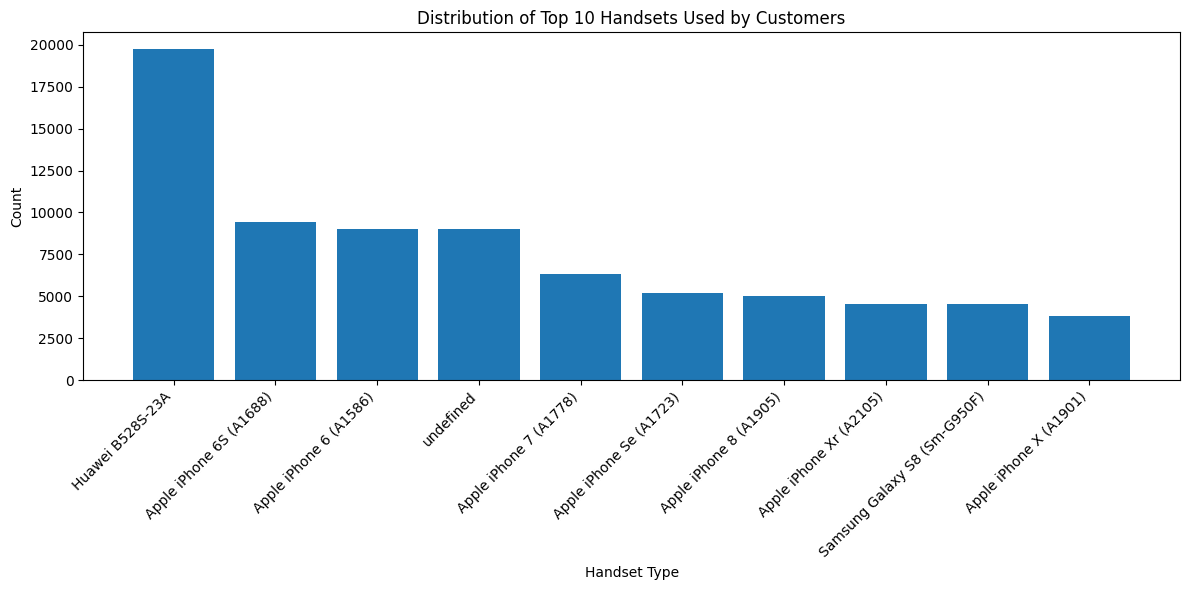

In [3]:
# Top 10 handsets used by customers
top_10_handsets = xdr_data['Handset Type'].value_counts().head(10)

print("Top 10 Handsets Used by Customers:")
print(top_10_handsets)

# Improved visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_handsets.index, top_10_handsets.values)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.title('Distribution of Top 10 Handsets Used by Customers')
plt.xlabel('Handset Type')
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

## Identifying the top 3 handset manufacturers

Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64


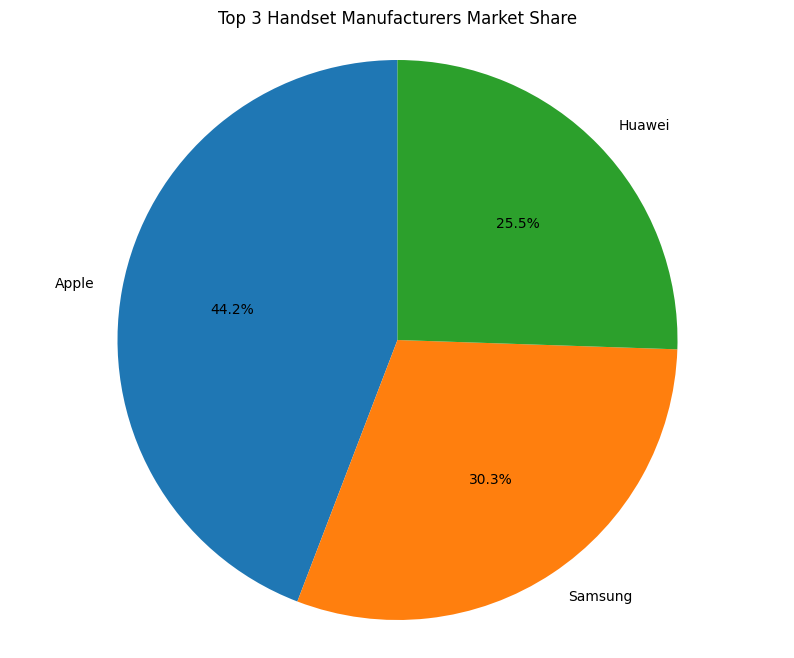

In [4]:
# Top 3 handset manufacturers
top_3_manufacturers = xdr_data['Handset Manufacturer'].value_counts().head(3)

print("Top 3 Handset Manufacturers:")
print(top_3_manufacturers)

#  Visualization
plot_pie_chart(top_3_manufacturers, title='Top 3 Handset Manufacturers Market Share')

## Identifying the top 5 handsets per top 3 manufacturers

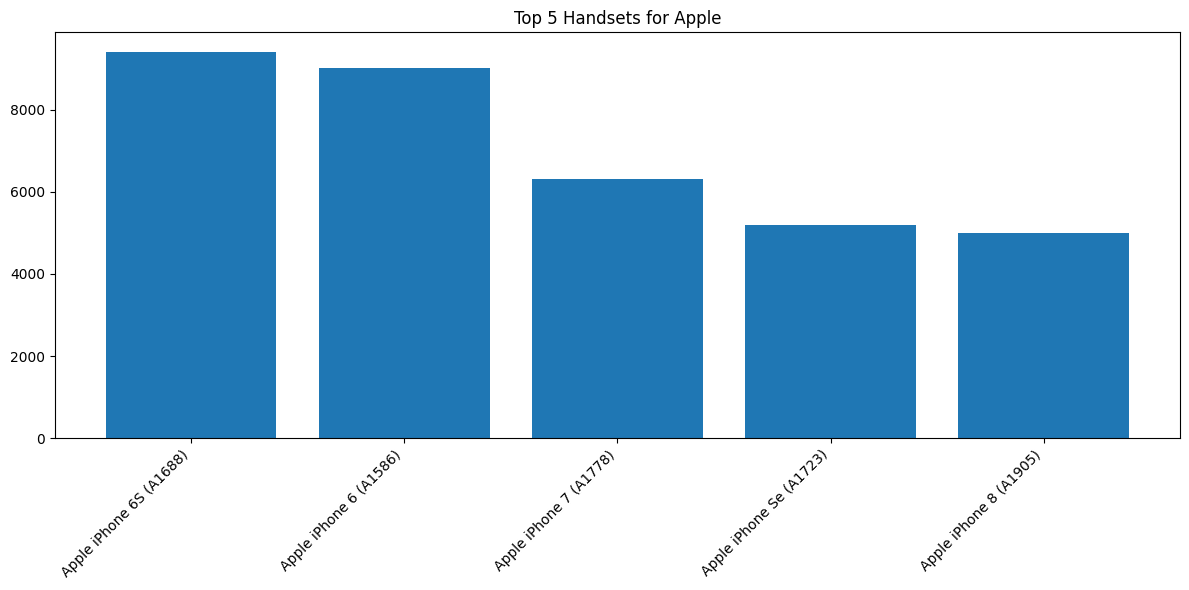

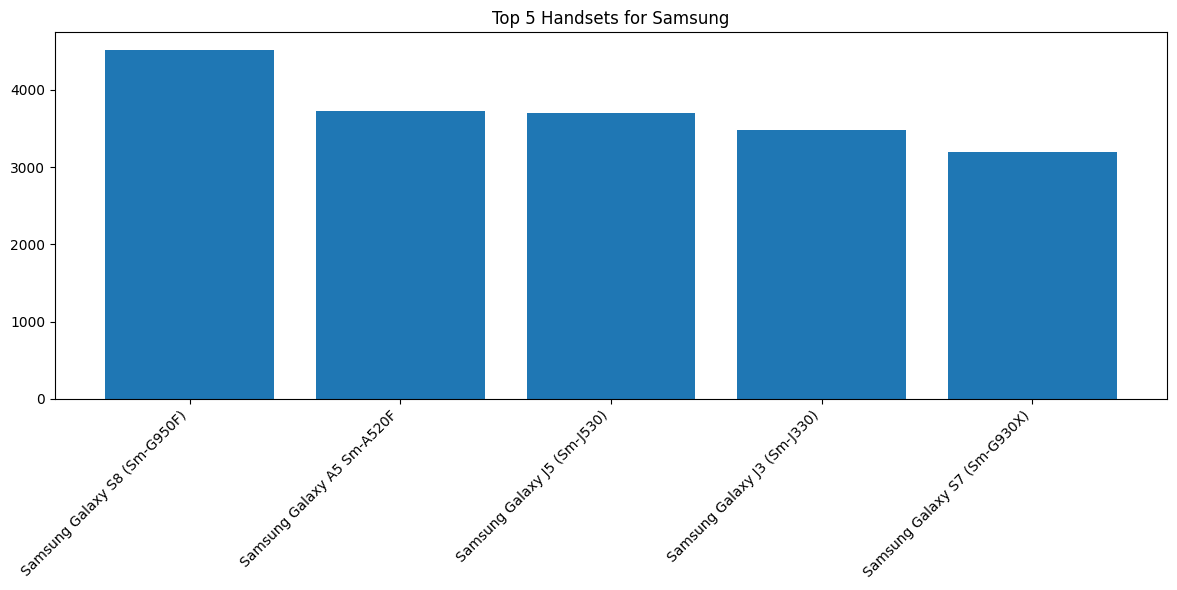

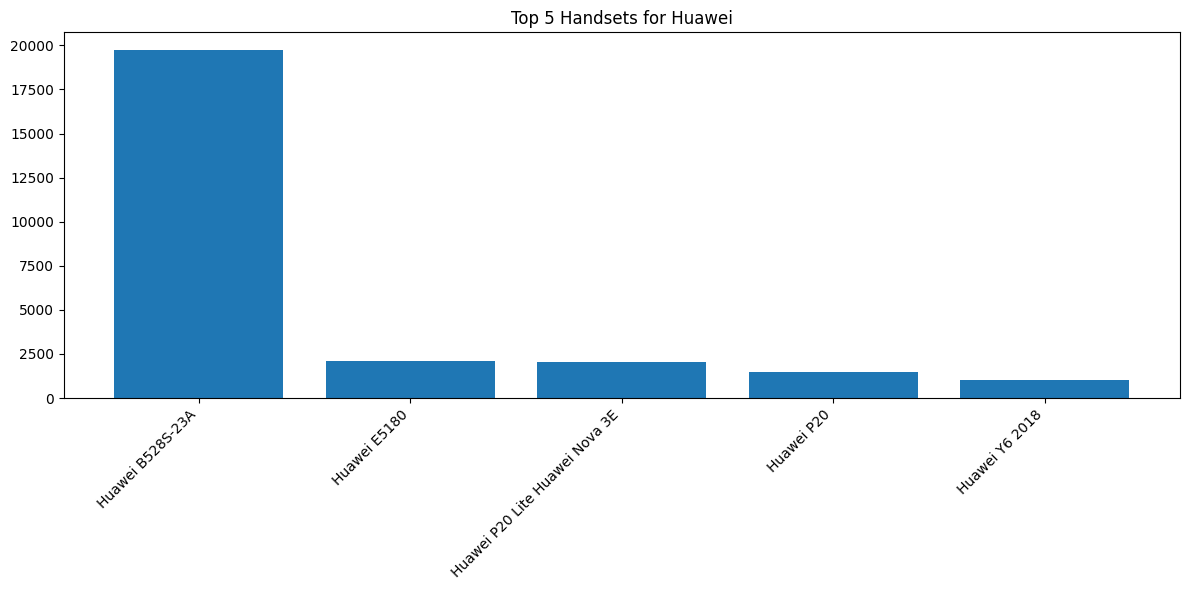

In [6]:
# Filter data for the top 3 manufacturers
top_3_manufacturer_names = top_3_manufacturers.index
filtered_data = xdr_data[xdr_data['Handset Manufacturer'].isin(top_3_manufacturer_names)]

# Top 5 handsets per manufacturer
top_5_handsets_per_manufacturer = (
    filtered_data.groupby('Handset Manufacturer')['Handset Type']
    .value_counts()
    .groupby(level=0)
    .head(5)
)

# Convert the multi-index Series to a DataFrame for easier plotting
plot_data = pd.DataFrame(top_5_handsets_per_manufacturer).reset_index()
plot_data.columns = ['Manufacturer', 'Handset', 'Count']

# Create separate plots for each manufacturer
for manufacturer in top_3_manufacturer_names:
    manufacturer_data = plot_data[plot_data['Manufacturer'] == manufacturer]
    plot_bar_chart(
        pd.Series(data=manufacturer_data['Count'].values, index=manufacturer_data['Handset']),
        title=f'Top 5 Handsets for {manufacturer}'
    )

## Aggregating per-user metrics (Task 1.1)

In [7]:
# Aggregating metrics per user
user_metrics = xdr_data.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  # Number of sessions
    'Dur. (ms)': 'sum',    # Total session duration
    'Total DL (Bytes)': 'sum',  # Total download
    'Total UL (Bytes)': 'sum',  # Total upload
})

# Adding total data volume column
user_metrics['Total Data Volume (Bytes)'] = (
    user_metrics['Total DL (Bytes)'] + user_metrics['Total UL (Bytes)']
)

user_metrics = user_metrics.rename(columns={
    'Bearer Id': 'Number of xDR Sessions',
    'Dur. (ms)': 'Total Session Duration (ms)',
    'Total DL (Bytes)': 'Total Download (Bytes)',
    'Total UL (Bytes)': 'Total Upload (Bytes)',
})

print("Aggregated User Metrics:")
print(user_metrics.head())

Aggregated User Metrics:
               Number of xDR Sessions  Total Session Duration (ms)  \
MSISDN/Number                                                        
3.360100e+10                        1                     116720.0   
3.360100e+10                        1                     181230.0   
3.360100e+10                        1                     134969.0   
3.360101e+10                        1                      49878.0   
3.360101e+10                        2                      37104.0   

               Total Download (Bytes)  Total Upload (Bytes)  \
MSISDN/Number                                                 
3.360100e+10             8.426375e+08            36053108.0   
3.360100e+10             1.207552e+08            36104459.0   
3.360100e+10             5.566597e+08            39306820.0   
3.360101e+10             4.019932e+08            20327526.0   
3.360101e+10             1.363130e+09            94280527.0   

               Total Data Volume (Bytes)  

## Handling missing values and outliers (Task 1.2)

In [10]:
# Handling missing values: Replacing with column means
xdr_data_filled = xdr_data.fillna(xdr_data.mean(numeric_only=True))

# Removing or flagging outliers using z-scores
from scipy.stats import zscore

numeric_columns = xdr_data_filled.select_dtypes(include='number')
z_scores = numeric_columns.apply(zscore)
outliers = (z_scores > 3).any(axis=1)  # Flag rows with any z-score > 3

# Remove or analyze outliers
cleaned_data = xdr_data_filled[~outliers]

print("Cleaned Data without Outliers:")
print(cleaned_data.head())

Cleaned Data without Outliers:
       Bearer Id            Start  Start ms             End  End ms  \
62  1.304243e+19   4/21/2019 2:55      73.0  4/25/2019 0:17   262.0   
65  1.311448e+19   4/21/2019 8:26     605.0  4/25/2019 1:20   655.0   
66  7.349883e+18   4/21/2019 8:54     105.0  4/25/2019 0:48   931.0   
67  1.311448e+19   4/21/2019 9:19     590.0  4/25/2019 4:42   965.0   
68  1.304243e+19  4/21/2019 10:09       1.0  4/25/2019 1:39   272.0   

    Dur. (ms)          IMSI  MSISDN/Number          IMEI Last Location Name  \
62   336160.0  2.082018e+14   3.376353e+10  8.637690e+13            D72939C   
65   320001.0  2.082017e+14   3.366364e+10  3.564211e+13            L11120C   
66   316419.0  2.082019e+14   3.366010e+10  3.579881e+13            L11864B   
67   329003.0  2.082021e+14   3.365079e+10  3.575751e+13            D73388C   
68   314961.0  2.082014e+14   3.366274e+10  3.528141e+13            T72937C   

    ...  Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)

### Step 1: Describe all relevant variables and associated data types


In [11]:
# Describing the dataset
print("Dataset Info:")
print(xdr_data.info())

print("\nSummary Statistics for Numeric Columns:")
print(xdr_data.describe())

print("\nSummary Statistics for Non-Numeric Columns:")
print(xdr_data.describe(include='object'))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RT

### Step 2: Variable transformations


In [12]:
# Decile segmentation based on total session duration
user_metrics['Duration Decile'] = pd.qcut(
    user_metrics['Total Session Duration (ms)'], 
    5, 
    labels=['1st Decile', '2nd Decile', '3rd Decile', '4th Decile', '5th Decile']
)

# Compute total data per decile
decile_data = user_metrics.groupby('Duration Decile').agg({
    'Total Download (Bytes)': 'sum',
    'Total Upload (Bytes)': 'sum',
    'Total Data Volume (Bytes)': 'sum'
})

print("Data Metrics Per Decile:")
print(decile_data)

Data Metrics Per Decile:
                 Total Download (Bytes)  Total Upload (Bytes)  \
Duration Decile                                                 
1st Decile                 1.059394e+13          9.547430e+11   
2nd Decile                 1.152621e+13          1.044428e+12   
3rd Decile                 1.060947e+13          9.605178e+11   
4th Decile                 1.281675e+13          1.157958e+12   
5th Decile                 2.216321e+13          2.006209e+12   

                 Total Data Volume (Bytes)  
Duration Decile                             
1st Decile                    1.154869e+13  
2nd Decile                    1.257064e+13  
3rd Decile                    1.156998e+13  
4th Decile                    1.397471e+13  
5th Decile                    2.416942e+13  


### Step 3: Non-graphical univariate analysis


In [13]:
# Dispersion parameters
dispersion_metrics = user_metrics.describe().loc[['mean', '50%', 'std', 'min', 'max']]

print("Dispersion Metrics:")
print(dispersion_metrics)

Dispersion Metrics:
      Number of xDR Sessions  Total Session Duration (ms)  \
mean                1.389777                 1.461672e+05   
50%                 1.000000                 1.027400e+05   
std                 0.809863                 1.863587e+05   
min                 0.000000                 7.142000e+03   
max                18.000000                 1.855375e+07   

      Total Download (Bytes)  Total Upload (Bytes)  Total Data Volume (Bytes)  
mean            6.336527e+08          5.730942e+07               6.909621e+08  
50%             5.703677e+08          4.679387e+07               6.179231e+08  
std             4.645551e+08          3.565765e+07               4.910559e+08  
min             8.827082e+06          2.866892e+06               3.324901e+07  
max             8.156743e+09          7.295774e+08               8.846226e+09  


### Step 4: Graphical univariate analysis


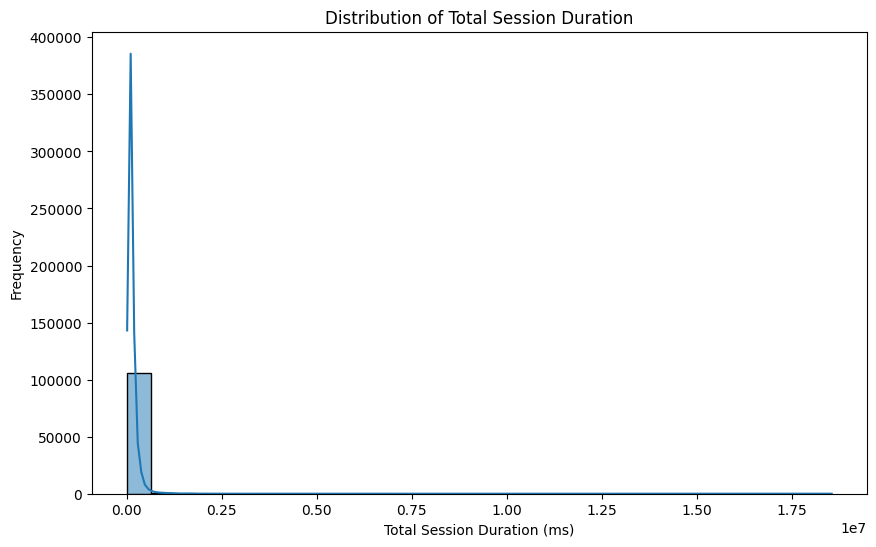

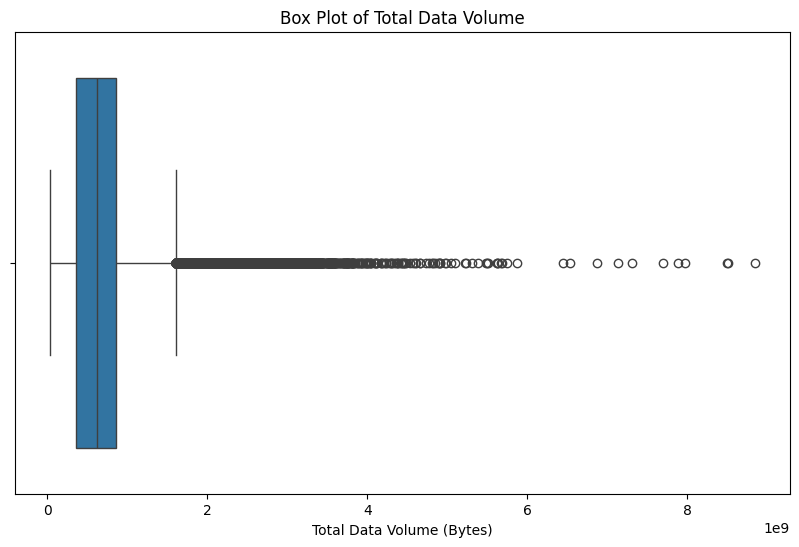

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Total Session Duration
plt.figure(figsize=(10, 6))
sns.histplot(user_metrics['Total Session Duration (ms)'], bins=30, kde=True)
plt.title("Distribution of Total Session Duration")
plt.xlabel("Total Session Duration (ms)")
plt.ylabel("Frequency")
plt.show()

# Box plot for Total Data Volume
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_metrics['Total Data Volume (Bytes)'])
plt.title("Box Plot of Total Data Volume")
plt.xlabel("Total Data Volume (Bytes)")
plt.show()

### Step 5: Bivariate analysis


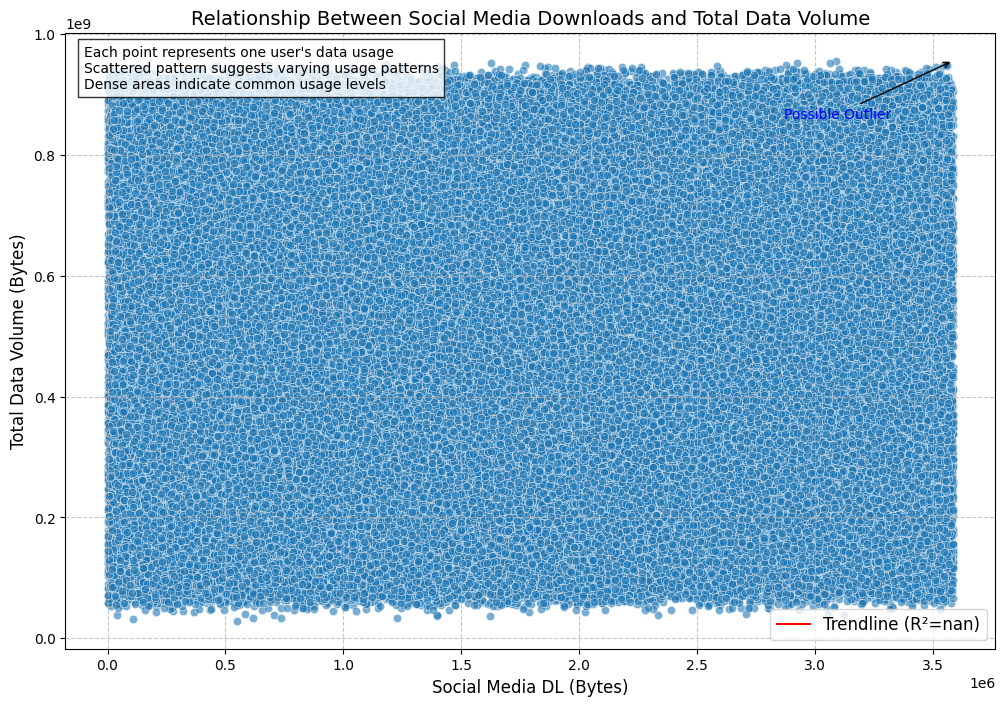

In [21]:
import numpy as np
from scipy.stats import linregress

# Scatter plot with enhancements
plt.figure(figsize=(12, 8))

# Scatter points
sns.scatterplot(x=xdr_data['Social Media DL (Bytes)'], 
                y=xdr_data['Total Data Volume (Bytes)'], alpha=0.6)

# Trendline calculation and plotting
slope, intercept, r_value, p_value, std_err = linregress(
    xdr_data['Social Media DL (Bytes)'], 
    xdr_data['Total Data Volume (Bytes)']
)
x_vals = np.linspace(xdr_data['Social Media DL (Bytes)'].min(), 
                     xdr_data['Social Media DL (Bytes)'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label=f"Trendline (R²={r_value**2:.2f})")

# Adding labels and a grid
plt.title("Relationship Between Social Media Downloads and Total Data Volume", fontsize=14)
plt.xlabel("Social Media DL (Bytes)", fontsize=12)
plt.ylabel("Total Data Volume (Bytes)", fontsize=12)

# Add explanatory text
plt.text(0.02, 0.98, 
             'Each point represents one user\'s data usage\n'
             'Scattered pattern suggests varying usage patterns\n'
             'Dense areas indicate common usage levels',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Optional: Highlight outliers or specific regions
plt.annotate('Possible Outlier', xy=(xdr_data['Social Media DL (Bytes)'].max(), 
                                     xdr_data['Total Data Volume (Bytes)'].max()), 
             xytext=(0.8 * xdr_data['Social Media DL (Bytes)'].max(), 
                     0.9 * xdr_data['Total Data Volume (Bytes)'].max()),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=10, color='blue')

plt.show()

### Step 6: Correlation analysis


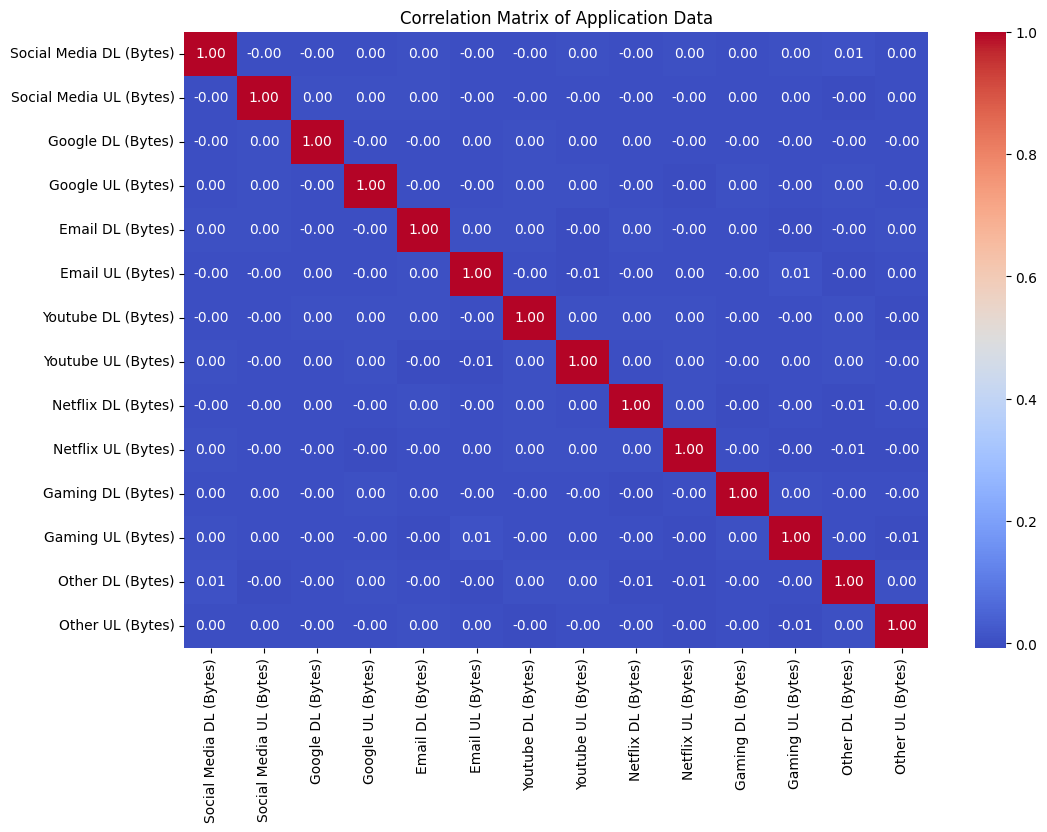

In [16]:
# Correlation matrix
app_columns = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

correlation_matrix = xdr_data[app_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Application Data")
plt.show()


### Step 7: Dimensionality reduction using PCA

Explained Variance Ratio by PCA Components:
[0.07259283 0.07242906 0.07211392 0.07197411 0.0717675 ]


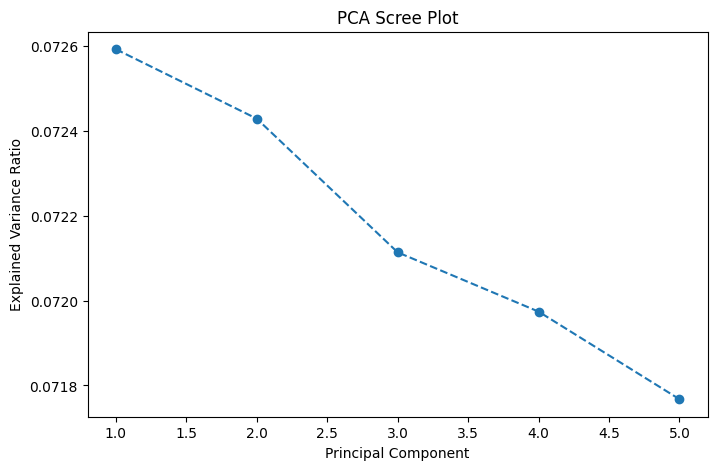

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
app_data_scaled = scaler.fit_transform(xdr_data[app_columns].dropna())

# PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(app_data_scaled)

# Variance explained by components
print("Explained Variance Ratio by PCA Components:")
print(pca.explained_variance_ratio_)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("PCA Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()